# 1. VK Social network analysis


## 1.1 Downloading vk friends information 

In [1]:
import json
import requests
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import warnings
import random
warnings.filterwarnings('ignore')

In [2]:
def get_friends_info(user_id, access_token, fields=None):
    if fields is None:
        fields = 'sex'
    api = 'https://api.vk.com/method/'
    friends_url = f'{api}friends.get?fields={fields}&user_id={user_id}&access_token={access_token}&v=5.21'

    json_response = requests.get(friends_url).json()
    if json_response.get('error'):
        raise KeyError(f'Inable to access {user_id} friends.')

    return json_response[u'response'], friends_url

In [3]:
user_id = 
fields = 'sex,city,education,bdate' # check https://vk.com/dev/users.get for all possible fields values
access_token =  # put your token

mates, url = get_friends_info(user_id, access_token, fields)

## 1.2 Building an egocentric graph

In [4]:
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

In [5]:
ids = []
first_name = []
last_name = []
sex = []
bdate = []
city = []
university_name = []
faculty_name = []
graduation = []
friends_ids = []
def put_val(item,field,keys):
    if field in keys:
        return item[field]
    else:
        return ''
    
for num_item,item in enumerate(mates['items']):
    try:
        mates1, _ = get_friends_info(item['id'], access_token, fields)
        friends = [kitem['id'] for kitem in mates1['items']]
        friends_ids.append(friends)
    except:
        continue
        
    ids.append(item['id'])
    first_name.append(item['first_name'])
    last_name.append(item['last_name'])
    
    
    keys = item.keys()
    if 'city' in keys:
        city.append(item['city']['title'])
    else:
        city.append('')
    
    bdate.append(put_val(item,'bdate',keys))
    sex.append(put_val(item,'sex',keys))
    university_name.append(put_val(item,'university_name',keys))
    faculty_name.append(put_val(item,'faculty_name',keys))
    graduation.append(put_val(item,'graduation',keys))

    d = {'ids': ids, 'first_name': first_name, 'ids': ids, 'last_name': last_name,
     'sex': sex, 'bdate': bdate, 'city': city, 'university_name': university_name,
     'faculty_name': faculty_name, 'graduation': graduation,'friends_ids':friends_ids}      

In [6]:
Users = pd.DataFrame(data=d)

In [7]:
Users.to_excel('Users.xlsx',index=False)

In [8]:
matrix = np.zeros((Users.shape[0],Users.shape[0]))
edges = []
for col_num,id_1 in tqdm_notebook(enumerate(ids)):
    for row_num,id_2 in enumerate(ids):
        if id_1 == id_2:
            matrix[col_num,row_num] = 0
            continue
        
        friends1 = friends_ids[col_num]
        friends2 = friends_ids[row_num]
        
        if  id_1 in friends2 and id_2 in friends1:
            matrix[col_num,row_num] = 1
            if not (row_num,col_num) in edges:
                edges.append((col_num,row_num))
        else:
            matrix[col_num,row_num] = 0
        

In [9]:
df_edges = pd.DataFrame(data=edges, columns=['source', 'target'])

In [10]:
G = nx.from_pandas_edgelist(df_edges)

In [11]:
VK = G

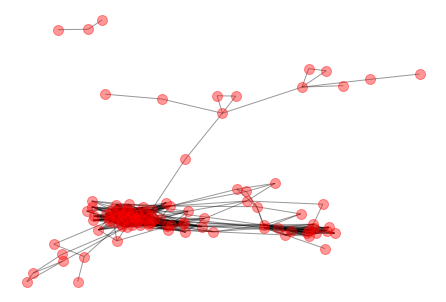

In [12]:
nx.draw(G, node_size = 100, node_color = 'r', alpha = 0.4, font_size  = 8)

###  https://networkx.github.io/documentation/stable/auto_examples/index.html

## 1.3 The analysis of the resulting egocentric network


1. Analyse simple network properties: #vertices, #edges, #connected components.
2. Plot nodes degree distribution, does power law hold for your network?
3. Compute centrality measures for your network: degree, closeness, betweenness, eigenvector; interpret the ranking results.
4. Using different layouts plot you network, use different node characteristics as node size/color. You could also download meta data to use it for node coloring: gender, age, city, etc.
5. (optional) Find network communities using either igraph or community package, analyse the results.

### 1. Simple network properties

#### Number of nodes

In [13]:
G.number_of_nodes()

106

My graph should contain more nodes, but due to the fact that some of my friends have closed pages, the nodes with these friends had to be deleted previously as they are not representative.

#### Number of edges

In [14]:
G.number_of_edges()

944

#### Number of connected components

In [15]:
len(list(nx.connected_components(G)))

2

My graph has 2 connected components. One of them is my friend from music school (nodes number 21, 29 and 57) and another one is all other freinds. 

In [16]:
#Users.iloc[21], Users.iloc[29], Users.iloc[57]

### 2. Nodes degree distribution

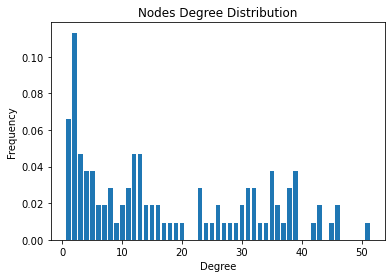

In [17]:
degrees = G.degree() #nodes degree
degree_values = sorted([d for n, d in G.degree()], reverse=True) 
histogram = [list(degree_values).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

plt.bar(degree_values, histogram)

plt.title("Nodes Degree Distribution")
plt.ylabel("Frequency")
plt.xlabel("Degree")

plt.show()

Let's find out who of my friends knows the biggest amount of my other friends (which node has the biggest degree):

In [18]:
per = max(dict(degrees), key=dict(degrees).get)
print(*(Users.iloc[per].first_name, Users.iloc[per].last_name))

Pasha Chubko


#### Power Law and Nodes Degree Distribution

In [19]:
import collections
from sklearn.linear_model import LinearRegression

d, f = zip(*collections.Counter(degree_values).items())

In [20]:
d = np.array(d)
f = np.array(f)

#log-log scale
d = np.log(d)
f = np.log(f)

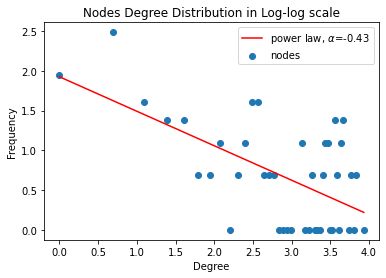

In [21]:
plt.scatter(d, f, label='nodes')
plt.title('Nodes Degree Distribution in Log-log scale')

lm = LinearRegression()
lm.fit(d[None].T,f)

plt.plot(d, lm.intercept_+lm.coef_*d, 'r', label='power law, '+r'$\alpha$='+f'{round(lm.coef_[0],2)}')

plt.legend()
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

As it can be seen, Power Law does not hold for Nodes Degree Distribution of this graph.

### 3. Centrality measures

#### Degree centrality

In [22]:
dgr = list(nx.degree_centrality(G).values())

In [23]:
dgr, frq = np.unique(dgr, return_counts=True)

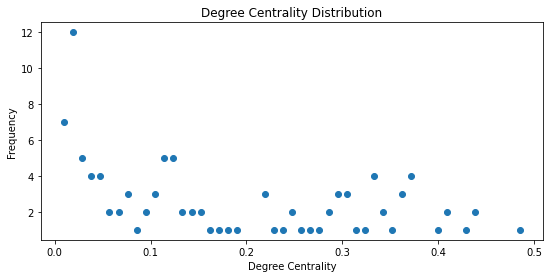

In [24]:
plt.figure(figsize=(9,4))

plt.scatter(dgr, frq)

plt.title("Degree Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Degree Centrality")

plt.show()

#### Closeness Centrality

In [25]:
cls = list(nx.closeness_centrality(G).values())

In [26]:
cls, frq = np.unique(cls, return_counts=True)

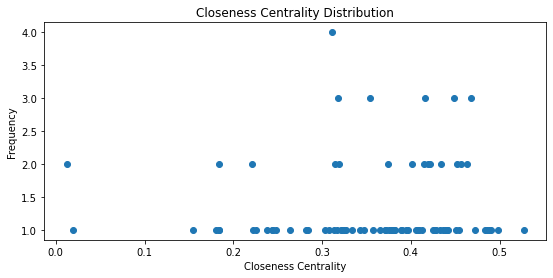

In [27]:
plt.figure(figsize=(9,4))

plt.scatter(cls, frq)

plt.title("Closeness Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Closeness Centrality")

plt.show()

#### Betweenness Centrality

In [28]:
btw = list(nx.betweenness_centrality(G).values())

In [29]:
btw, frq = np.unique(btw, return_counts=True)

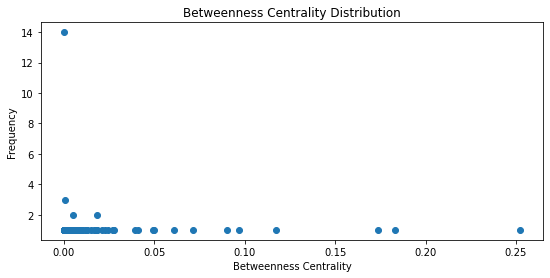

In [30]:
plt.figure(figsize=(9,4))

plt.scatter(btw, frq)

plt.title("Betweenness Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Betweenness Centrality")

plt.show()

#### Eigenvector Centrality

In [31]:
eig = list(nx.eigenvector_centrality(G, max_iter=100, tol=1e-3).values())

In [32]:
eig, frq = np.unique(eig, return_counts=True)

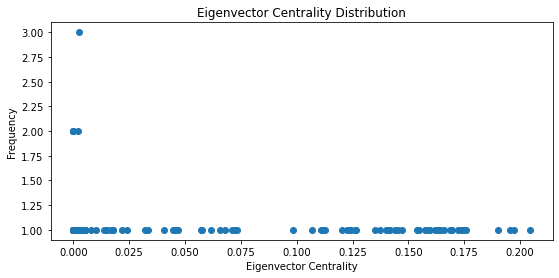

In [33]:
plt.figure(figsize=(9,4))

plt.scatter(eig, frq)

plt.title("Eigenvector Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Eigenvector Centrality")

plt.show()

### 4. Plot the Network

Now let's plot the Network. I will divide people by gender and by city they came from. 

In [34]:
pos = nx.kamada_kawai_layout(G) 

In [35]:
fi = {num_id : Users.iloc[num_id]['first_name']+ ' ' + Users.iloc[num_id]['last_name'] for num_id in G.nodes()}

In [36]:
gender = {num_id: Users['sex'].replace({1:'Women',2:'Men'}).iloc[num_id] for num_id in G.nodes()}

In [37]:
city = {num_id : Users.iloc[num_id]['city'] for num_id in G.nodes()}

Set the color of the node according to the city/gender:

In [38]:
def make_node_color(f_dict,limit=1):
    result = {}
    cnt = 1
    for key,val in pd.Series(list(f_dict.values())).value_counts().items():
        if val >limit:
            result[key] = cnt
            cnt +=1
        else:
            result[key] = 0
    return result

In [39]:
city_col = make_node_color(city)
gender_col = make_node_color(gender)

Set the size of the node depending on Degree Centrality:

In [40]:
nod_dgr = nx.degree_centrality(G)
nod_siz = [2000*nod_dgr[num_id] for num_id in G.nodes()]

##### Let's plot the graph colored by cities:

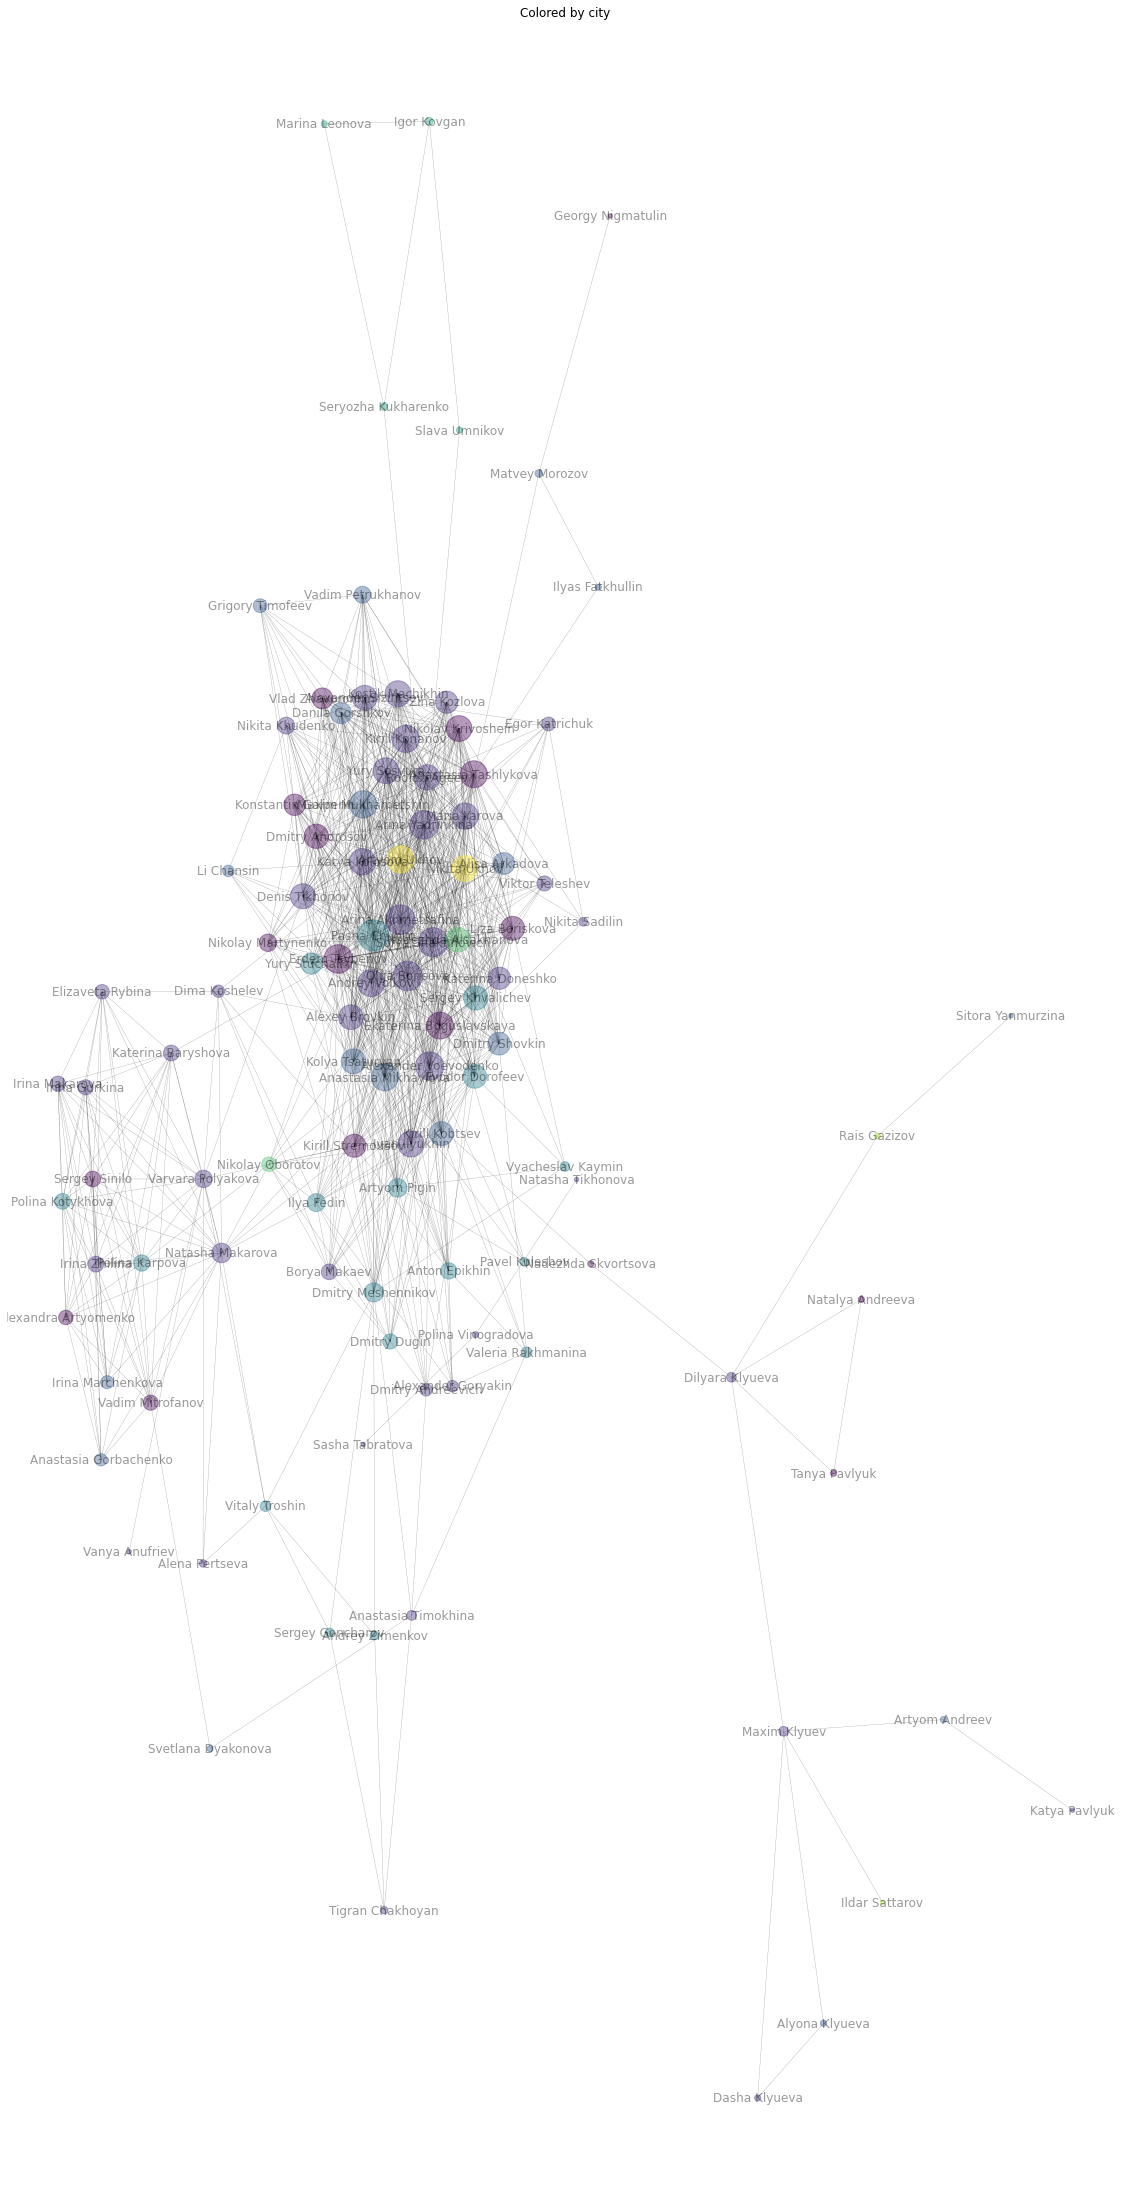

In [41]:
n_col = [city_col[city[num_id]] for num_id in G.nodes()]

plt.figure(figsize=(20,40))
plt.title('Colored by city')
nx.draw(G,
        pos,
        node_color=n_col, 
        node_size=nod_siz, 
        alpha=0.4, 
        labels=fi,
        width=0.3
        )
plt.show()

##### Let's plot the graph colored by genders:

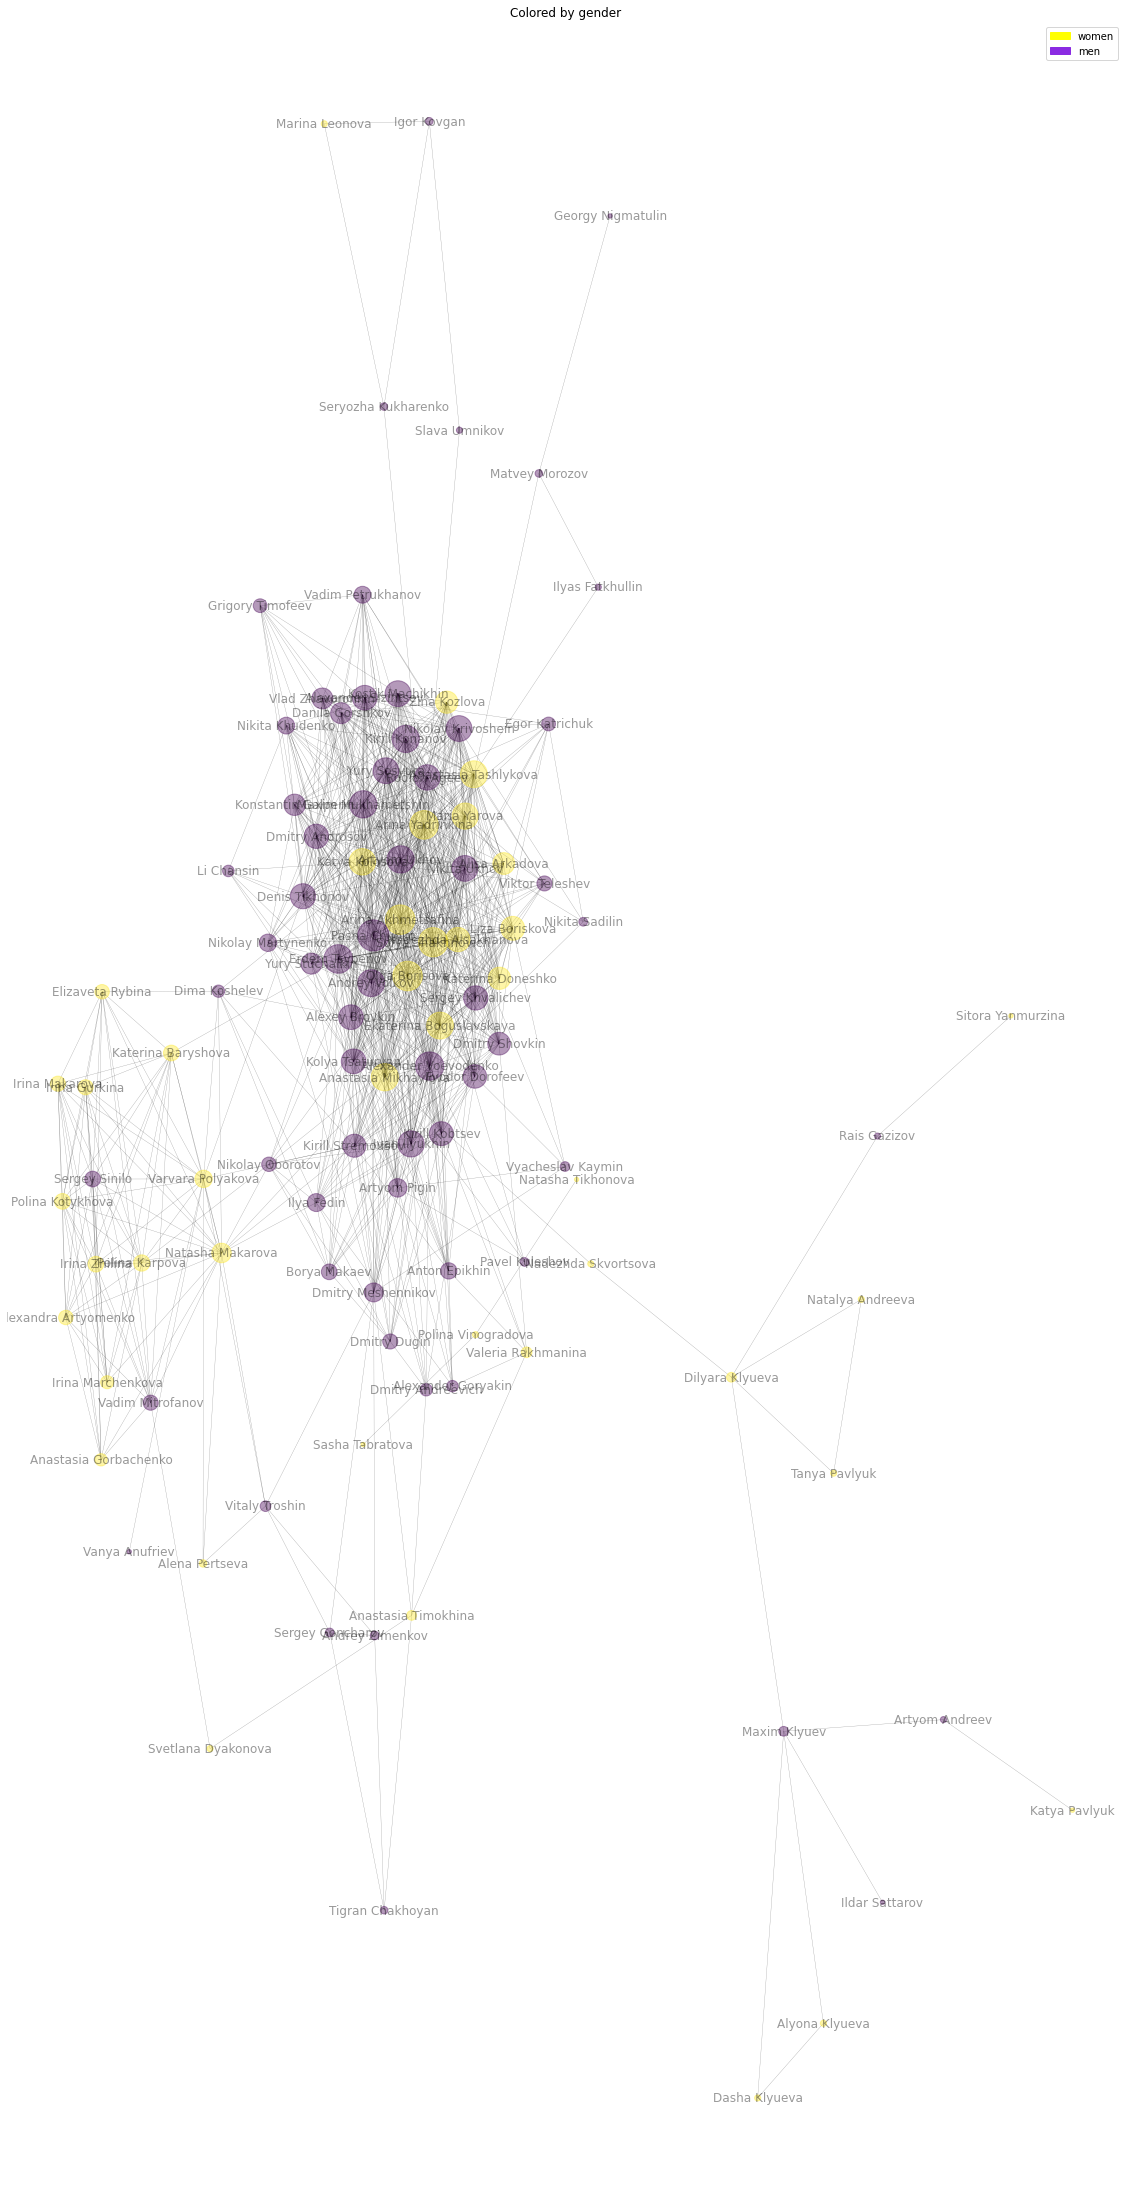

In [42]:
n_col = [gender_col[gender[num_id]] for num_id in G.nodes()]

plt.figure(figsize=(20,40))
plt.title('Colored by gender')
nx.draw(G,
        pos,
        node_color=n_col, 
        node_size=nod_siz, 
        alpha=0.4, 
        labels=fi,
        width=0.3)
women_patch = mpatches.Patch(color='yellow', label='women')
men_patch = mpatches.Patch(color='blueviolet', label='men')
plt.legend(handles=[women_patch,men_patch])
plt.show()

### 5. Network communities

##### I calculated the number of clusters/groups that has my VK Graph:
1. Bachelor friends (the greatest amount of people in the centre)
2. Classmates and there friends (located on the left)
3. Relatives and family friends (located on the right)
4. Friends from magistracy (located at the bottom)
5. Friends from Krasnoyarsk (located at the bottom)
6. Friends from night school (located below)
7. Friends from music scool (they can't be clearly seen on the graph)

Let's use community library and check it.

In [43]:
import community as community_louvain
partition = community_louvain.best_partition(VK)

In [44]:
partition_col = make_node_color(partition)

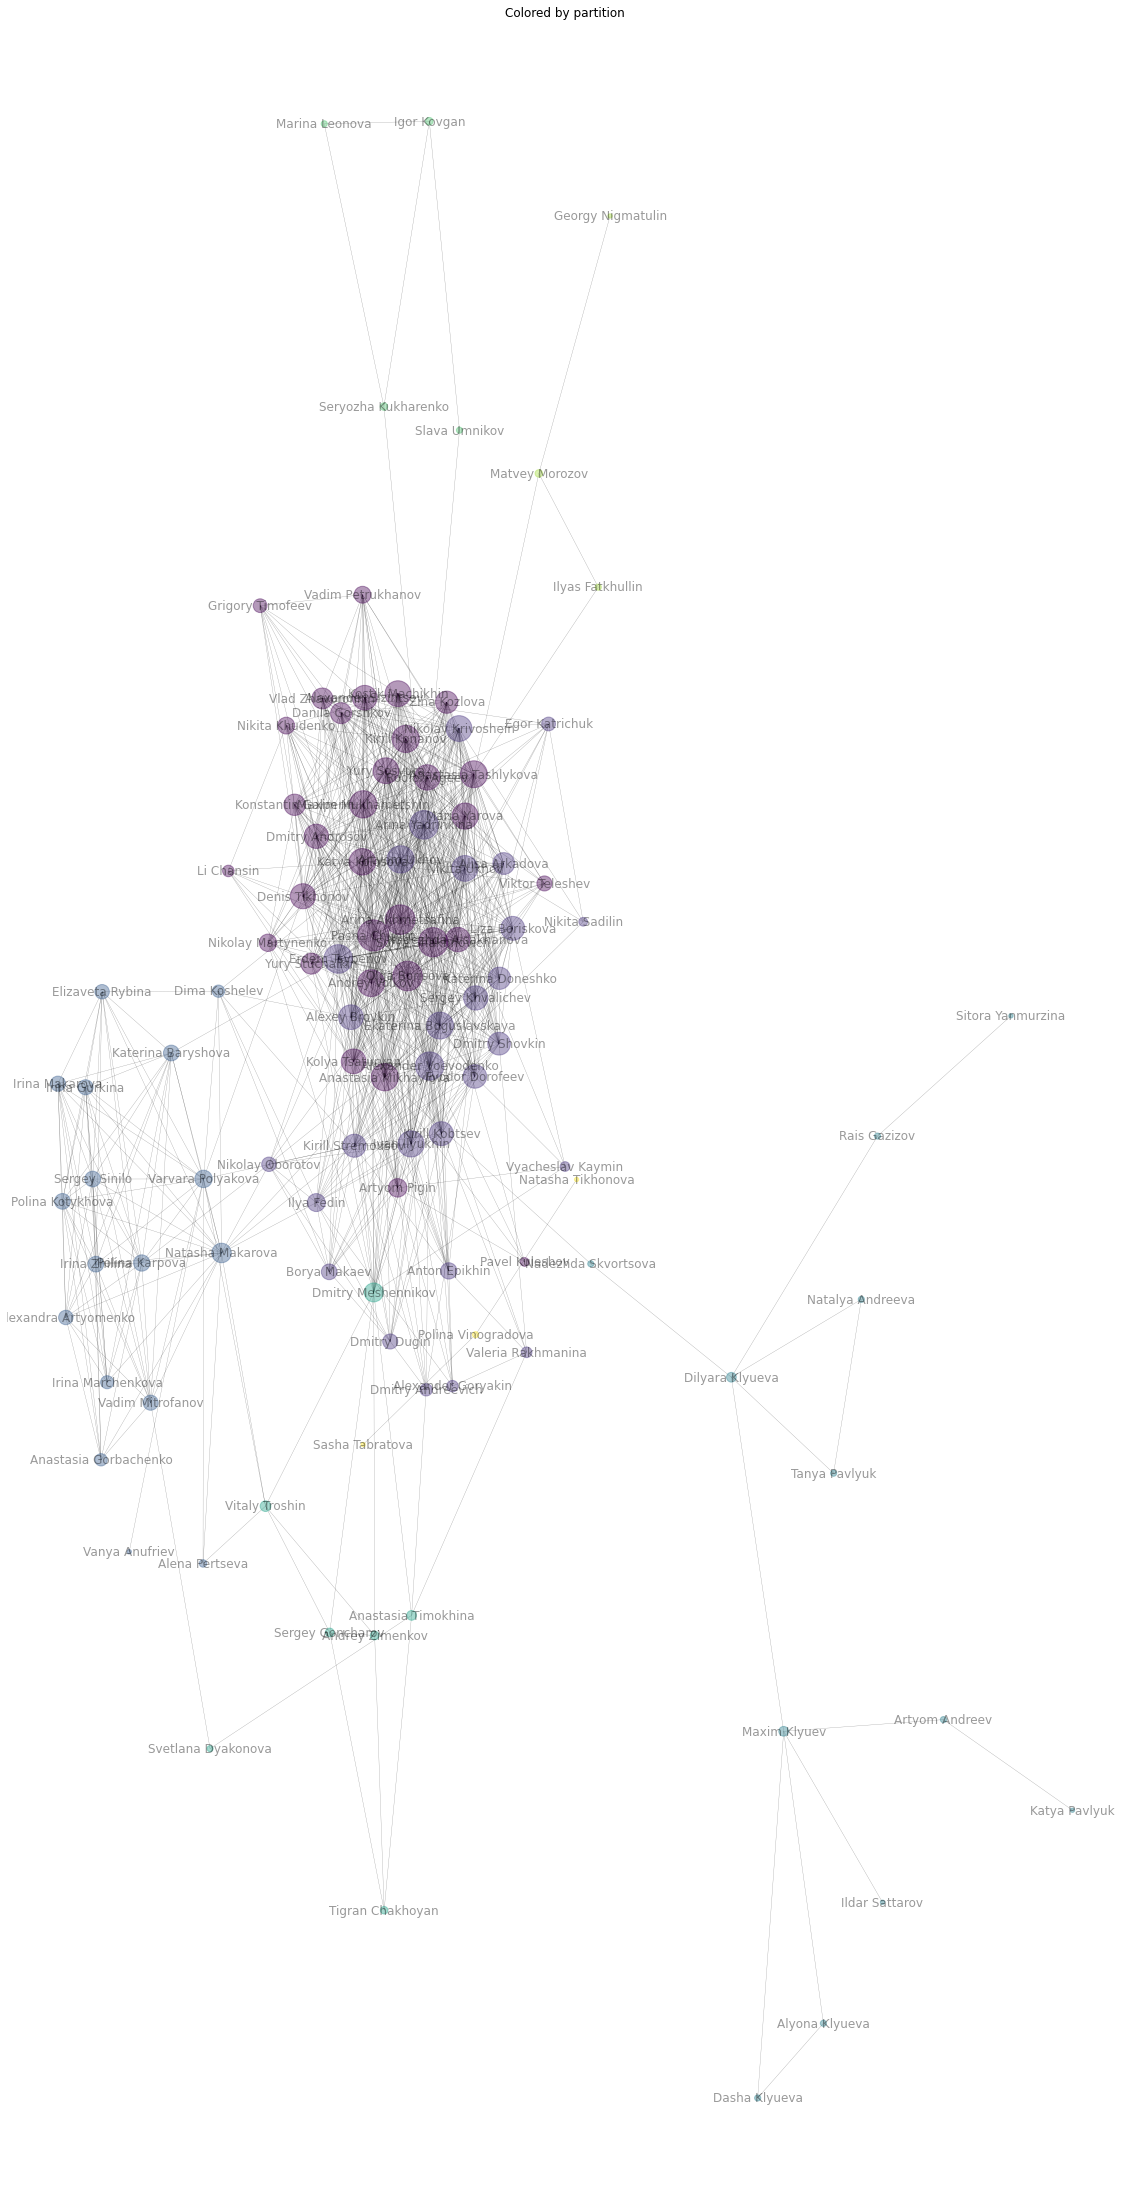

In [45]:
n_col = [partition_col[partition[num_id]] for num_id in G.nodes()]

plt.figure(figsize=(20,40))
plt.title('Colored by partition')
nx.draw(G,
        pos,
        node_color=n_col, 
        node_size=nod_siz, 
        alpha=0.4, 
        labels=fi,
        width=0.3)
plt.show()

##### We can see the groups of people I highlighted before on the VK Graph.

# 2. Random graphs models

### 2.1 Preferential Attachement Model

#### Preferential Attachement Model using NetworkX

In [46]:
BA_nx = nx.barabasi_albert_graph(106,1) #number of nodes = 106, number of edges to attach from a new node to existing nodes = 2

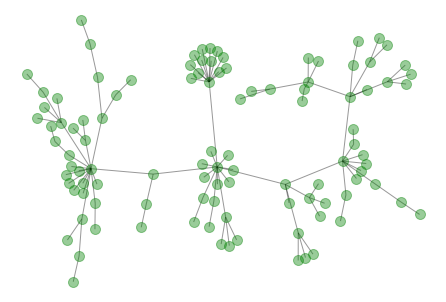

In [47]:
nx.draw(BA_nx, node_size = 100, node_color = 'g', alpha = 0.4, font_size  = 8)

#### Preferential Attachement Model (my algorithm)

In [48]:
def barabasi_albert(n , m): 
    """
    :Parameters: 
    - `n`: the number of nodes 
    - `m`: number of edges to attach from a new node to existing nodes  
    
    return: edges of Graph (list of tuples)

    """ 

    if m < 1 or n <= m: 
        print('InputError!')
        return [] 
    
    dict_nodes = {}
    edges = [(0,1)]
    
    for i in range(2,n):
        for el in edges[-1]:
            if el in dict_nodes:
                dict_nodes[el]+=1
            else:
                dict_nodes[el] = 1
        probs = np.array(list(dict_nodes.values()))
        probs = probs/sum(probs)
        choosed_nodes = random.choices(list(dict_nodes.keys()),k=m,weights=probs)
        for ch_node in choosed_nodes:
            edges.append((ch_node,i))
    
    return edges

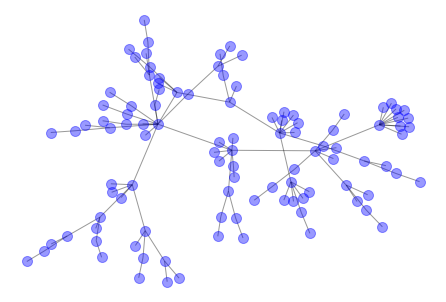

In [49]:
edges_ba =  barabasi_albert(106 , 1)
df_edges_ba = pd.DataFrame(data=edges_ba, columns=['source', 'target'])
BA = nx.from_pandas_edgelist(df_edges_ba)
nx.draw(BA, node_size = 100, node_color = 'b', alpha = 0.4, font_size  = 8)

#### Nodes Degree Distribution for Barabasi Albert Graph

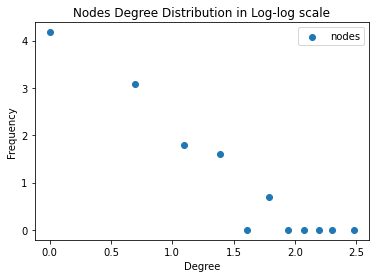

In [50]:
degrees = BA.degree() 
degree_values = sorted([d for n, d in BA.degree()], reverse=True) 
d, f = zip(*collections.Counter(degree_values).items())

d = np.array(d)
f = np.array(f)

d = np.log(d)
f = np.log(f)

plt.scatter(d, f, label='nodes')
plt.title('Nodes Degree Distribution in Log-log scale')

plt.legend()
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

#### Centrality measures

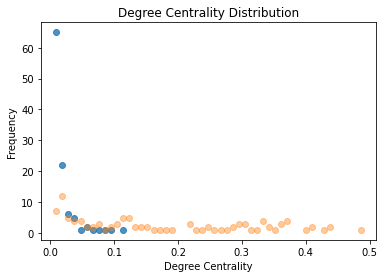

In [51]:
#VK - orange color, Preferential Attachement Model - blue color

dgr_b = list(nx.degree_centrality(BA).values())
dgr_vk = list(nx.degree_centrality(VK).values())

d_b, f_b = np.unique(dgr_b, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)


plt.scatter(d_b, f_b, alpha = 0.8)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Degree Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Degree Centrality")

plt.show()

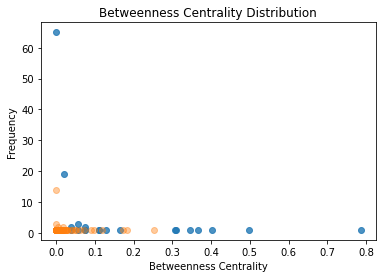

In [52]:
#VK - orange color, Preferential Attachement Model - blue color

dgr_b = list(nx.betweenness_centrality(BA).values())
dgr_vk = list(nx.betweenness_centrality(VK).values())

d_b, f_b = np.unique(dgr_b, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_b, f_b, alpha = 0.8)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Betweenness Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Betweenness Centrality")

plt.show()

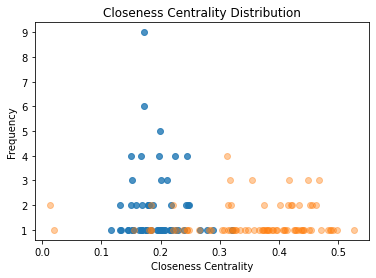

In [53]:
#VK - orange color, Preferential Attachement Model - blue color

dgr_b = list(nx.closeness_centrality(BA).values())
dgr_vk = list(nx.closeness_centrality(VK).values())

d_b, f_b = np.unique(dgr_b, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_b, f_b, alpha = 0.8)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Closeness Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Closeness Centrality")

plt.show()

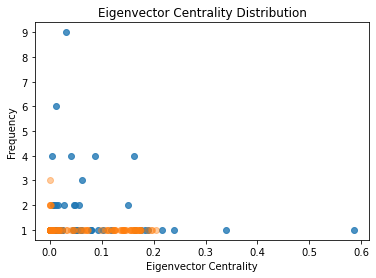

In [54]:
#VK - orange color, Preferential Attachement Model - blue color

dgr_b = list(nx.eigenvector_centrality(BA).values())
dgr_vk = list(nx.eigenvector_centrality(VK).values())

d_b, f_b = np.unique(dgr_b, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_b, f_b, alpha = 0.8)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Eigenvector Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Eigenvector Centrality")

plt.show()

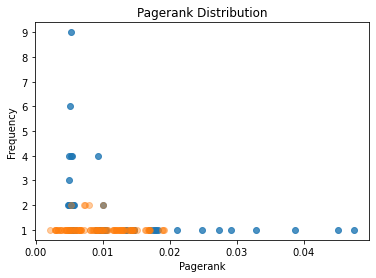

In [55]:
#VK - orange color, Preferential Attachement Model - blue color

dgr_b = list(nx.pagerank(BA).values())
dgr_vk = list(nx.pagerank(VK).values())

d_b, f_b = np.unique(dgr_b, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_b, f_b, alpha = 0.8)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Pagerank Distribution")
plt.ylabel("Frequency")
plt.xlabel("Pagerank")

plt.show()

### 2.2 Configuration Model

I will use and build a configuration model without self loops and parallel edges.

#### Configuration Model using NetworkX

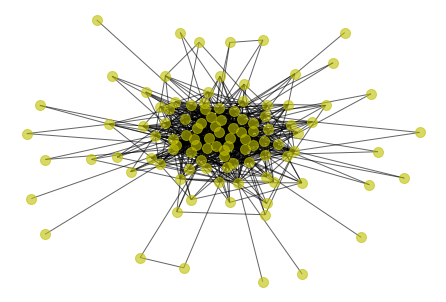

In [56]:
sequence = [d for n, d in VK.degree()] #degree sequence is taken from VK graph
Conf_nx=nx.configuration_model(sequence)
Conf_nx=nx.Graph(Conf_nx)
nx.draw(Conf_nx, node_size = 100, node_color = 'y', alpha = 0.6, font_size  = 8)

#### Configuration Model (my algorithm)

In [57]:
import random

def configuration_graph(sequence):
    '''
    sequence (list)
    return edges of Graph (list of tuples)
    '''
    if not sum(sequence)%2 ==0:
        sequence[0] += 1
        
    if len(sequence)==0 or max(sequence)==0:
        print('InputError!')
        return []

    temp_list=[]
    for n,val in enumerate(sequence):
        temp_list += val*[n]

    random.shuffle(temp_list)
    edges = []
    while temp_list:
        n1 = temp_list.pop()
        n2 = temp_list.pop()
        if ((n1,n2) not in  edges) and ((n2,n1) not in  edges):
            edges.append((n1,n2))
    return edges

Set the list that contains the degree of each node:

In [58]:
sequence = [d for n, d in VK.degree()] 
edges_config =  configuration_graph(sequence)

In [59]:
df_edges_config = pd.DataFrame(data=edges_config, columns=['source', 'target'])
G_config = nx.from_pandas_edgelist(df_edges_config)

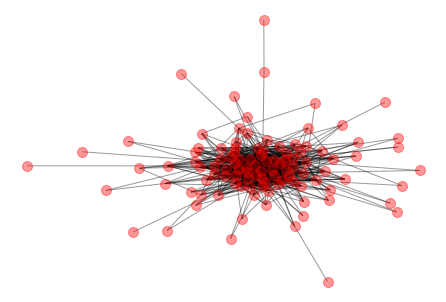

In [60]:
nx.draw(G_config, node_size = 100, node_color = 'r', alpha = 0.4, font_size  = 8)

#### Centrality measures

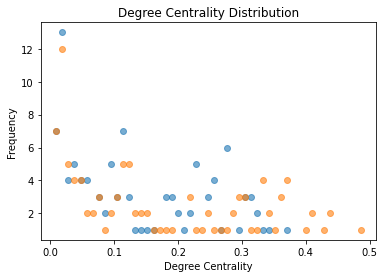

In [61]:
#VK - orange color, Configuration Model - blue color

dgr_c = list(nx.degree_centrality(G_config).values())
dgr_vk = list(nx.degree_centrality(VK).values())

d_c, f_c = np.unique(dgr_c, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_c, f_c, alpha = 0.6)
plt.scatter(d_vk, f_vk, alpha = 0.6)

plt.title("Degree Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Degree Centrality")

plt.show()

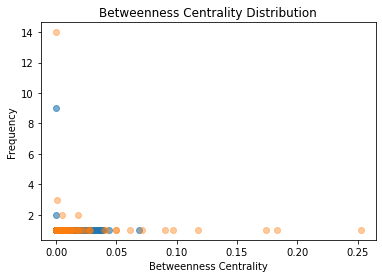

In [62]:
#VK - orange color, Configuration Model - blue color

dgr_c = list(nx.betweenness_centrality(G_config).values())
dgr_vk = list(nx.betweenness_centrality(VK).values())

d_c, f_c = np.unique(dgr_c, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_c, f_c, alpha = 0.6)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Betweenness Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Betweenness Centrality")

plt.show()

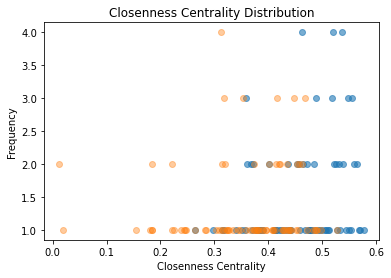

In [63]:
#VK - orange color, Configuration Model - blue color

dgr_c = list(nx.closeness_centrality(G_config).values())
dgr_vk = list(nx.closeness_centrality(VK).values())

d_c, f_c = np.unique(dgr_c, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_c, f_c, alpha = 0.6)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Closenness Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Closenness Centrality")

plt.show()

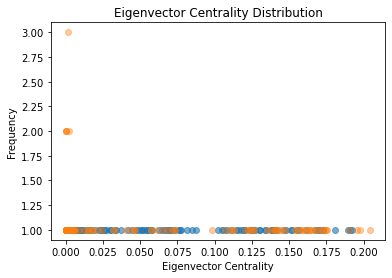

In [64]:
#VK - orange color, Configuration Model - blue color

dgr_c = list(nx.eigenvector_centrality(G_config).values())
dgr_vk = list(nx.eigenvector_centrality(VK).values())

d_c, f_c = np.unique(dgr_c, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_c, f_c, alpha = 0.6)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Eigenvector Centrality Distribution")
plt.ylabel("Frequency")
plt.xlabel("Eigenvector Centrality")

plt.show()

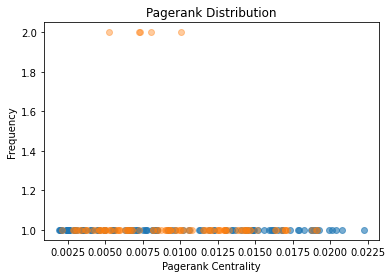

In [65]:
#VK - orange color, Configuration Model - blue color

dgr_c = list(nx.pagerank(G_config).values())
dgr_vk = list(nx.pagerank(VK).values())

d_c, f_c = np.unique(dgr_c, return_counts = True)
d_vk, f_vk = np.unique(dgr_vk, return_counts = True)

plt.scatter(d_c, f_c, alpha = 0.6)
plt.scatter(d_vk, f_vk, alpha = 0.4)

plt.title("Pagerank Distribution")
plt.ylabel("Frequency")
plt.xlabel("Pagerank Centrality")

plt.show()

#### Having studied the distributions of various centrality metrics, we can come to the conclusion that the second model better describes the graph of Vk friends as the distributions are more similar between Configuration Model graph and VK graph.

# 3. Отправка решения.


1. Прогоните свой jupyter notebook: **Kernel** $\rightarrow$ **Restart & Run all**, нотбук **должен** запускаться линейно!
2. Удалите всю персональную информацию (замените access_token на пустую строку, удалите напечатанные pandas таблицы с метаданными и пр.)
3. Назовите нотбук `Имя_Фамилия_HA1_networks_2020`, например `Anvar_Kurmukov_HA1_networks_2020`
4. Сохраните нотбук в формате `html` и в формате `ipython`
5. Отправьте эти два файла на почту kurmukovai@gmail.com с темой письма `Имя_Фамилия_HA1_networks_2020`.